## 决策树

**工作原理**：得到一个原始数据集，然后基于最好的属性值划分数据集，由于特征值可能多于两个，因此可能存在大于两个分支的数据集划分。  
              第一次划分之后，数据将被向下传递到树分支的下一个节点，在这个节点上，我们可以再次划分数据。如此反复，直至程序遍历  
              完所有划分数据集的属性或者每个分支下的所有实例都具有相同的分类。

### 计算给定数据集的香农熵

In [197]:
from math import log
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] +=1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob*log(prob,2)
    return shannonEnt

### 创建数据集

In [198]:
def createDataSet():
    dataSet = [[1,1,'yes'],
              [1,1,'yes'],
              [1,0,'no'],
              [0,1,'no'],
              [0,1,'no']]
    labels = ['no surfacing','flippers']
    return dataSet, labels

### 按照给定的特征划分数据集

In [199]:
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]   #去掉axis特征
            reducedFeatVec.extend(featVec[axis+1:]) #将符合条件的添加到返回的数据集
            retDataSet.append(reducedFeatVec)  
    return retDataSet   #返回划分后的数据集

### 根据信息增益最大原则，选择最好的数据集划分方式
特征$A$对训练集$D$的信息增益$g(D,A)$，定义为集合$D$的经验熵$H(D)$与特征$A$给定条件下$D$的经验条件熵$H(D|A)$之差，即  
               $$g(D,A) = H(D) - H(D|A)$$

设训练数据集为$D$，$|D|$表示其样本容量，即样本个数。设有$K$个类$C_k$，$k=1,2,…,K$，$|C_k|$为属于类$C_k$的样本个数，$\sum_{k=1}^K|C_k|=|D|$。
设特征$A$有$n$个不同的取值${a_1,a_2,…,a_n}$，根据特征$A$的取值将$D$划分为$n$个子集$D_1,D_2,…,D_n$，$|D_i|$为$D_i$的样本个数，$\sum_{i=1}^n|D_i|=|D|$。  
记子集$D_i$中属于类$C_k$的样本的集合为$D_ik$，即$D_{ik}=D_i\bigcap C_k$，$|D_{ik}|$为$D_{ik}$的样本个数，于是信息增益的算法如下：  
输入：训练数据集$D$和特征$A$；  
输出：特征$A$对训练数据集$D$的信息增益$g(D,A)$。  
（1）计算数据集$D$的经验熵$H(D)$   
$$H(D) = -\sum_{k=1}^K\frac{|C_k|}{|D|}log_2\frac{|C_k|}{|D|}$$
（2）计算特征$A$对数据集$D$的经验条件熵$H(D|A)$
$$H(D|A) = \sum_{i=1}^n\frac{|D_i|}{|D|}H(D_i)=-\sum_{i=1}^n\frac{|D_i|}{|D|}\sum_{k=1}^K\frac{|D_{ik}|}{|D_i|}log_2\frac{|D_{ik}|}{|D_i|}$$
（3）计算信息增益
$$g(D,A) = H(D) - H(D|A)$$

In [200]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1  
    baseEntropy = calcShannonEnt(dataSet) #计算整个数据集的原始香农熵
    bestInfoGain = 0.0  #信息增益
    bestFeature = -1   #最优特征的索引值
    for i in range(numFeatures):
        #获取dataSet的第i个特征
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)   #创建set集合，元素不可重复
        newEntropy = 0.0    #经验条件熵
        for value in uniqueVals:    #计算信息增益
            subDataSet = splitDataSet(dataSet, i, value)  #subDataSet划分后的子集
            prob = len(subDataSet)/float(len(dataSet))   #计算子集的概率
            newEntropy += prob*calcShannonEnt(subDataSet)  #根据公式计算经验条件熵
        infoGain = baseEntropy - newEntropy   #计算信息增益
        if(infoGain > bestInfoGain):    
            bestInfoGain = infoGain    #更新信息增益，找到最大的信息增益
            bestFeature = i    #记录最大信息增益的特征索引值
    return bestFeature   #返回信息增益最大的特征的索引值

### 用多数表决的方法决定该叶子节点的分类

In [201]:
import operator
def majorityCnt(classList):
    classCount = {}
    for vote in classList:    #统计classList中每个元素出现的个数
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(),key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]   #返回classList中出现次数最多的元素

### 创建树的代码

In [202]:
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]   #取分类标签
    if classList.count(classList[0]) == len(classList):  #如果类别完全相同则停止继续划分
        return classList[0]
    if len(dataSet[0]) == 1:    #遍历完所有特征时返回出现次数最多的类标签
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)  #选择最优特征
    bestFeatLabel = labels[bestFeat]   #最优特征的标签
    myTree = {bestFeatLabel:{}}    #根据最优特征的标签生成树
    del(labels[bestFeat])    #删除已经使用特征标签
    featValues =[example[bestFeat] for example in dataSet]    #得到训练集中所有最优特征的属性值
    uniqueVals = set(featValues)   #去掉重复的属性值
    for value in uniqueVals:   #遍历特征，创建决策树。
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree

### 获取叶节点的数目和树的层数

In [203]:
def getNumLeafs(myTree):
    numLeafs = 0
    #firstStr = myTree.keys()[0]
    #python3中myTree.keys()返回的是dict_keys,不再是list,所以不能使用myTree.keys()[0]的方法获取结点属性，可以使用list(myTree.keys())[0]
    firstStr = next(iter(myTree))                                
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            numLeafs += getNumLeafs(secondDict[key])
        else: numLeafs += 1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = next(iter(myTree))   
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            thisDepth = 1+getTreeDepth(secondDict[key])
        else: thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

### 使用文本注解绘制树节点

In [204]:
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle="sawtooth", fc='0.8')  #设置节点格式
leafNode = dict(boxstyle="round4", fc='0.8')   #设置叶节点格式
arrow_args = dict(arrowstyle="<-")   #定义箭头格式

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',va='center',
                            ha='center',bbox=nodeType,arrowprops=arrow_args)   #绘制节点

def plotMidText(cntrPt, parentPt, txtString):    #计算标注位置
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid,yMid, txtString)

def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)   #获取决策树叶结点数目，决定了树的宽度
    depth = getTreeDepth(myTree)  #获取决策树层数
    firstStr = next(iter(myTree)) 
    cntrPt = (plotTree.xOff +(1.0 + float(numLeafs))/2.0/plotTree.totalW,plotTree.yOff) #中心位置
    plotMidText(cntrPt, parentPt, nodeTxt) #标注有向边属性值
    plotNode(firstStr, cntrPt, parentPt, decisionNode) #绘制结点
    secondDict = myTree[firstStr]  #下一个字典，也就是继续绘制子结点
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD #y偏移
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':  #测试该结点是否为字典，如果不是字典，代表此结点为叶子结点
            plotTree(secondDict[key],cntrPt,str(key))  #不是叶结点，递归调用继续绘制
        else:  #如果是叶结点，绘制叶结点，并标注有向边属性值 
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key],(plotTree.xOff,plotTree.yOff),cntrPt, leafNode)
            plotMidText((plotTree.xOff,plotTree.yOff),cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
    
def createPlot(inTree):
    fig = plt.figure(1,facecolor='white')  #创建fig
    fig.clf()  #清空fig
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)  #去掉x、y轴
    plotTree.totalW = float(getNumLeafs(inTree))  #获取决策树叶结点数目
    plotTree.totalD = float(getTreeDepth(inTree))  #获取决策树层数
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0  #x偏移
    plotTree(inTree,(0.5,0.1),'')    #绘制决策树
    plt.show() #显示绘制结果

### 使用决策树的分类函数

In [205]:
def classify(inputTree, featLabels, testVec):
    firstStr = inputTree.keys()[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__=='dict':
                classLabel = classify(secondDict[key],featLabels,testVec)
            else:   classLabel = secondDict[key]
    return classLabel

### 使用pickle模块存储决策树

In [206]:
def storeTree(inputTree, filename):
    import pickle
    fw = open(filename,'w')
    pickle.dump(inputTree,fw)
    fw.close()

def grabTree(filename):
    import pickle
    fr = open(filename)
    return pickle.load(fr)

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft', 'presbyopic': {'prescript': {'myope': 'no lenses', 'hyper': 'soft'}}, 'young': 'soft'}}, 'yes': {'prescript': {'myope': 'hard', 'hyper': {'age': {'pre': 'no lenses', 'presbyopic': 'no lenses', 'young': 'hard'}}}}}}, 'reduced': 'no lenses'}}


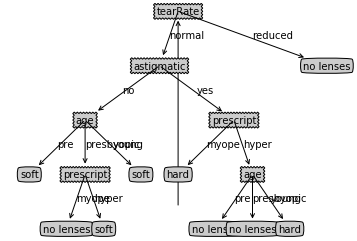

In [207]:
fr=open('lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age','prescript','astigmatic','tearRate']
lensesTree = createTree(lenses,lensesLabels)
print(lensesTree)
createPlot(lensesTree)